In [10]:
import cv2
from pycocotools.coco import COCO
from matplotlib import pyplot as plt
import numpy as np

In [102]:
coco = COCO('../instances_default.json')
coco.loadAnns([15])[0]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


{'id': 15,
 'image_id': 72,
 'category_id': 2,
 'segmentation': [[916.2,
   1188.0,
   910.6,
   1224.4,
   937.1,
   1238.53,
   958.7,
   1231.4,
   970.7,
   1197.9,
   946.7,
   1178.5]],
 'area': 2524.0,
 'bbox': [910.6, 1178.5, 60.1, 60.03],
 'iscrowd': 0,
 'attributes': {'occluded': False}}

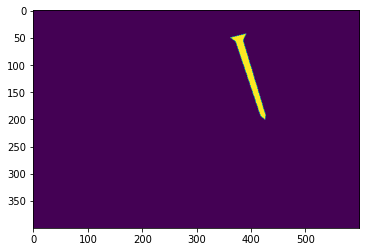

In [109]:
mask = coco.annToMask(coco.loadAnns([1])[0])
mask = cv2.resize(mask, (600, 400))
image = cv2.imread('../screws_001.png')
image = cv2.resize(image, (600, 400))
plt.imshow(mask)

[[335.19724771 293.13761468]]
[-0.24221838  0.97022176]


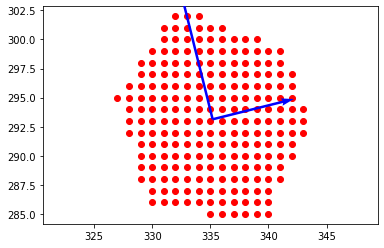

In [93]:
points = []
for i in range(mask.shape[0]):
	for j in range(mask.shape[1]):
		if mask[i, j] > 0:
			points.append([i, j])
points = np.array(points, dtype='float')
center, eig, cov = cv2.PCACompute2(points, mean=None)
print(center)
print(eig[:,0])
plt.plot(points[:, 0], points[:, 1], 'o', color='red', zorder=1)
plt.quiver(center[:, 0], center[:, 1], eig[0, 0], eig[0, 1], scale=2, zorder=3, color='blue')
plt.quiver(center[:, 0], center[:, 1], eig[1, 0], eig[1, 1], scale=4, zorder=3, color='blue')
plt.axis('equal')
plt.show()

18.43151691339353 15.037763096840276


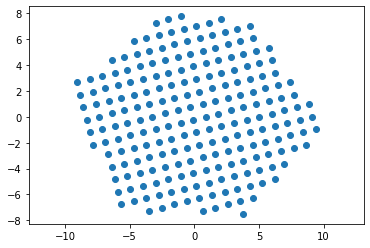

In [94]:
import math

points2 = cv2.PCAProject(points, center, eig)
midian = []
for it in points2:
	if math.fabs(0 - it[0]) < 2:
		midian.append(it[1])
print(np.ptp(points2[:, 0]), np.ptp(midian))
plt.plot(points2[:, 0], points2[:, 1], 'o')
plt.axis('equal')
plt.show()

### 实际拼装代码
只需要迁移这个下面的代码到c++就行了
注意下面程序只做了把识别到的结果画到图上，即plt.text()函数，迁移时还要在ROS输出
下面用了从标注中读取的bbox坐标进行绘图，迁移后需要从传回的mask中获取

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


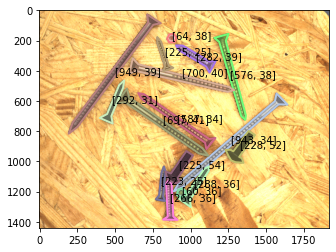

In [118]:
# 这里要从数据集读取标注和图片，到时候直接从ROS读取就可以了
coco = COCO('../instances_default.json')
anns = coco.getAnnIds()
out = cv2.imread('../screws_001.png')
# 采用了plt来做显示相关的操作，需要被迁移到qt+opencv上
b,g,r = cv2.split(out)
plt.imshow(cv2.merge([r,g,b]))
# 用了cocotools的函数显示mask，需要用opencv ployfill方法替代
coco.showAnns(coco.loadAnns(anns))
for annId in anns:
	# 加载mask信息，迁移到从ROS上获取
	ann = coco.loadAnns([annId])[0]
	mask = coco.annToMask(ann)

	# 构建PCA需要的数组，c++上用cv::Mat实现
	points = []
	for i in range(mask.shape[0]):
		for j in range(mask.shape[1]):
			if mask[i, j] > 0:
				points.append([i, j])
	points = np.array(points, dtype='float')
	# 调用opencv PCACompute2函数计算
	center, eig, cov = cv2.PCACompute2(points, mean=None)
	# 调用opencv PCAProject投影
	points2 = cv2.PCAProject(points, center, eig)

	# 如果是螺丝
	if ann['category_id'] == 1:
		# 获取x坐标在0附近的点，并计算其极差，作为螺丝直径
		midian = []
		for it in points2:
			if math.fabs(0 - it[0]) < 2:
				midian.append(it[1])
		# 取所有点中x坐标的极差作为螺丝长度
		plt.text(ann['bbox'][0] + ann['bbox'][2] / 2, ann['bbox'][1] + ann['bbox'][3] / 2
		         , str([int(np.ptp(points2[:, 0])), int(np.ptp(midian))]))
	# 如果是垫圈
	else:
		# 取所有点中x坐标的极差作为垫圈外径
		r = np.ptp(points2[:, 0])
		# 取垫圈外径0.6倍做垫圈内径
		plt.text(ann['bbox'][0] + ann['bbox'][2] / 2, ann['bbox'][1] + ann['bbox'][3] / 2
		         , str([int(r), int(r * 0.6)]))
plt.show()